In [1]:
import sys

sys.path.append(".")

import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from utils import read_msi
from pathlib import Path
from scipy import ndimage
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import MinMaxScaler
from pyimzml.ImzMLParser import ImzMLParser

# Define current folder using this file
CWD = "."
# Define folder that contains the revision chip type dataset
BASE_PATH = Path(os.path.join(CWD, "..", "data", "LONGITUDINAL"))
# Define folder that contains raw data
RAW_DATA = BASE_PATH.joinpath("raw")
# Define folder to save aligned data
ALIGNED_DATA = BASE_PATH.joinpath("aligned")
# Define folder to save processed data
PROCESSED_DATA = BASE_PATH.joinpath("processed")

In [2]:
def read_image_info(folder_name):
  msi_path = PROCESSED_DATA / folder_name / 'meaningful_signal.imzML'
  msi_seg = np.load(PROCESSED_DATA / folder_name / "segmentation_new.npy")

  with ImzMLParser(msi_path) as p:
    mzs, img = read_msi(p)
    mzs_filter = (mzs >= 600) & (mzs <= 900)
    img_filter = img[:, :, mzs_filter]

  return img_filter, mzs[mzs_filter], msi_seg


def perform_hierarchical_clustering(pixels, n_clusters):
  # Perform hierarchical clustering
  clustering = AgglomerativeClustering(
      n_clusters=n_clusters, linkage='ward', compute_distances=True
  )
  clustering.fit(pixels)
  return clustering


def plot_clusters(label_image, n_clusters=3, cbar=False):
  #
  tab10_cmap = plt.get_cmap('tab10')
  selected_colors = [tab10_cmap(i) for i in range(n_clusters)]
  colors = np.vstack(([1, 1, 1, 1], selected_colors))
  custom_cmap = ListedColormap(colors)

  #flipped_label_image = np.fliplr(label_image)
  seg_c_map = plt.imshow(label_image, cmap=custom_cmap, vmin=0, vmax=n_clusters)
  if cbar:
    cbar = plt.colorbar(
        seg_c_map, ticks=np.arange(1, n_clusters + 1),
        boundaries=np.arange(0.5, n_clusters + 1.5)
    )
    cbar.set_ticklabels(range(1, n_clusters + 1))
    cbar.set_label(
        'Cluster', labelpad=15, fontweight='bold', fontsize=14, color='0.2'
    )
    cbar.outline.set_edgecolor('0.2')
    cbar.ax.tick_params(labelsize=14, width=2.5, color='0.2')
    for l in cbar.ax.get_yticklabels():
      l.set_fontweight('bold')
      l.set_color('0.2')
  plt.axis('off')
  plt.tight_layout()
  plt.show()


def get_sample_name(s):
  if len(s.split("rep_")) > 1:
    return "day_" + s.split("day_")[1].split("_"
                                            )[0] + "_rep_" + s.split("rep_")[1]
  return "day_" + s.split("day_")[1].split("_")[0]

In [3]:
samples_groups = [
    ["tmz_1_tumor_brain_3_day_0_0_uM", "tmz_1_tumor_brain_3_day_5_0_uM_rep_1"],
    [
        "tmz_2_tumor_brain_3_day_0_1000_uM",
        "tmz_2_tumor_brain_3_day_5_1000_uM_rep_2"
    ], ["tmz_tumor_brain_4_day_0_0_uM", "tmz_tumor_brain_4_day_5_0_uM_rep_2"],
    [
        "tmz_tumor_brain_4_day_0_1000_uM",
        "tmz_tumor_brain_4_day_5_1000_uM_rep_2"
    ], ["tmz_tumor_brain_5_day_0_0_uM", "tmz_tumor_brain_5_day_5_0_uM_rep_3"],
    [
        "tmz_2_tumor_brain_5_day_0_1000_uM",
        "tmz_2_tumor_brain_5_day_5_1000_uM_rep_3"
    ], ["tmz_tumor_brain_6_day_0_0_uM", "tmz_tumor_brain_6_day_5_0_uM_rep_3"],
    [
        "tmz_tumor_brain_6_day_0_1000_uM",
        "tmz_tumor_brain_6_day_5_1000_uM_rep_2"
    ]
]

In [4]:
gaussian_sigma = 1.0
n_clusters = 4

img_original_list = []
img_list = []
mzs_list = []
seg_list = []

for sample in np.array(samples_groups).flatten():
  img, mzs, seg = read_image_info(sample)

  img_original_list.append(img)
  mzs_list.append(mzs)
  seg_list.append(seg)

  img[~seg] = 0

  img_smoothed = ndimage.gaussian_filter(img, sigma=gaussian_sigma)
  img_scaled = np.zeros_like(img)
  img_scaled[seg] = MinMaxScaler(clip=True).fit_transform(img_smoothed[seg])
  img_with_res = np.zeros_like(img)
  for i, mz in enumerate(mzs):
    mzs_mask = (mzs >= mz - 0.025) & (mzs <= mz + 0.025)
    img_with_res[:, :, i] = np.sum(img_scaled[:, :, mzs_mask], axis=-1)
  img_list.append(img_with_res)

In [129]:
# For each sample, plot its 3 lipids
gray_matter_mzs_filter = (
    (mzs_list[0] >= 600.51 - 0.025) & (mzs_list[0] <= 600.51 + 0.025)
)
tumour_mzs_filter = (
    (mzs_list[0] >= 682.64 - 0.025) & (mzs_list[0] <= 682.64 + 0.025)
)
white_matter_mzs_filter = (
    (mzs_list[0] >= 888.62 - 0.025) & (mzs_list[0] <= 888.62 + 0.025)
)

values_0 = {}
values_5 = {}
for i in range(0, len(samples_groups) * 2, 2):  
  for name, loop_filter in zip(
      ["gray_matter", "white_matter", "tumour"],
      [gray_matter_mzs_filter, white_matter_mzs_filter, tumour_mzs_filter]
  ):
    if values_0.get(name) is None:
      values_0[name] = {}
    if values_5.get(name) is None:
      values_5[name] = {}
    values_0[name][np.array(samples_groups).flatten()[i]] = img_list[i][seg_list[i]][:, loop_filter].mean(axis=-1).flatten()
    values_5[name][np.array(samples_groups).flatten()[i+1]] = img_list[i+1][seg_list[i+1]][:, loop_filter].mean(axis=-1).flatten()

In [138]:
flattened_data = []

for main_key, subdict in values_0.items():
    for sub_key, values in subdict.items():
        for value in values:
            flattened_data.append({'Category': main_key, 'Subcategory': sub_key, 'Value': value})

df_0 = pd.DataFrame(flattened_data)

flattened_data = []

for main_key, subdict in values_5.items():
    for sub_key, values in subdict.items():
        for value in values:
            flattened_data.append({'Category': main_key, 'Subcategory': sub_key, 'Value': value})
          
df_5 = pd.DataFrame(flattened_data)

In [140]:
def get_plot_name(name):
  split_1 = name.split("brain")[1]
  split_2 = split_1.split("day")
  return "barin" + split_2[0] + split_2[1].split("_")[2]

df_0["Subcategory"] = df_0["Subcategory"].apply(get_plot_name)
df_0["Day"] = "0"

df_5["Subcategory"] = df_5["Subcategory"].apply(get_plot_name)
df_5["Day"] = "5"
df = pd.concat([df_0, df_5])

In [157]:
from scipy.stats import ttest_ind

for category in df["Category"].unique():
  for sub_category in df["Subcategory"].unique():
    df_sub = df[(df["Category"] == category) & (df["Subcategory"] == sub_category)]
    t_stat_ind, p_value_ind = ttest_ind(df_sub[df_sub['Day'] == "0"]['Value'], df_sub[df_sub['Day'] == "5"]['Value'])
    print(category, sub_category, f"{t_stat_ind:.10f}", f"{p_value_ind:.10f}")

gray_matter barin_3_0 -25.9145880064 0.0000000000
gray_matter barin_3_1000 -31.9562254573 0.0000000000
gray_matter barin_4_0 -6.6578898679 0.0000000000
gray_matter barin_4_1000 -3.4904338233 0.0004846395
gray_matter barin_5_0 4.6312379207 0.0000037381
gray_matter barin_5_1000 -2.1871514312 0.0287740358
gray_matter barin_6_0 11.3603161589 0.0000000000
gray_matter barin_6_1000 3.7404168838 0.0001853243
white_matter barin_3_0 1.1988805587 0.2306198232
white_matter barin_3_1000 7.2066690429 0.0000000000
white_matter barin_4_0 20.5687592971 0.0000000000
white_matter barin_4_1000 25.2466099206 0.0000000000
white_matter barin_5_0 4.4372585731 0.0000093305
white_matter barin_5_1000 -19.1151008127 0.0000000000
white_matter barin_6_0 37.9942462287 0.0000000000
white_matter barin_6_1000 -24.3445868448 0.0000000000
tumour barin_3_0 -22.3351743514 0.0000000000
tumour barin_3_1000 -7.1991304147 0.0000000000
tumour barin_4_0 -10.0903373881 0.0000000000
tumour barin_4_1000 -4.9621893694 0.0000007103
t

gray_matter


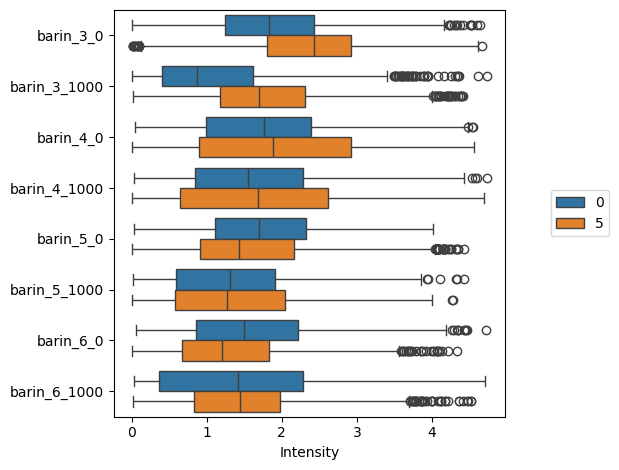

white_matter


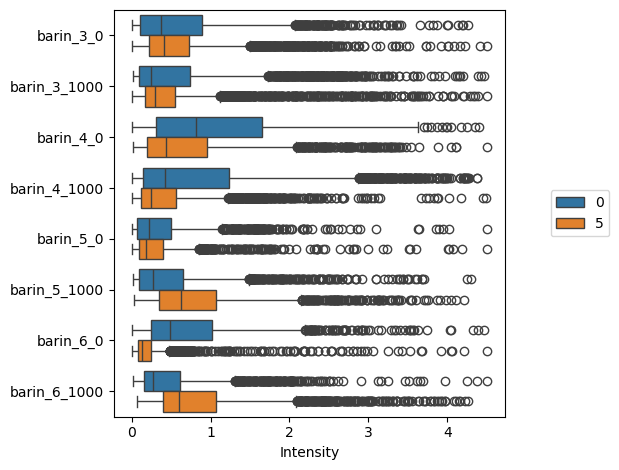

tumour


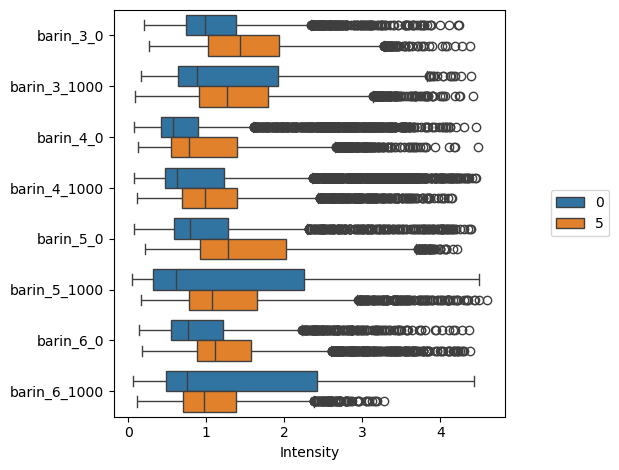

In [132]:


for category in ["gray_matter", "white_matter", "tumour"]:
  print(category)
  sns.boxplot(y='Subcategory', x='Value', hue="Day", data=df[df["Category"] == category])
  plt.ylabel("")
  plt.xlabel("Intensity")
  plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
  plt.tight_layout()
  plt.show()

In [134]:
from itertools import combinations

# For each sample, plot its 3 lipids
gray_matter_mzs_filter = (
    (mzs_list[0] >= 600.51 - 0.025) & (mzs_list[0] <= 600.51 + 0.025)
)
tumour_mzs_filter = (
    (mzs_list[0] >= 682.64 - 0.025) & (mzs_list[0] <= 682.64 + 0.025)
)
white_matter_mzs_filter = (
    (mzs_list[0] >= 888.62 - 0.025) & (mzs_list[0] <= 888.62 + 0.025)
)

all_corrs_0 = {}
all_corrs_5 = {}
for i in range(0, len(samples_groups) * 2, 2):
  vecs = {
    "gray_matter": img_list[i][seg_list[i]][:, gray_matter_mzs_filter].mean(axis=-1).flatten(),
    "white_matter": img_list[i][seg_list[i]][:, white_matter_mzs_filter].mean(axis=-1).flatten(),
    "tumour": img_list[i][seg_list[i]][:, tumour_mzs_filter].mean(axis=-1).flatten()
  }
  
  corrs = {}
  for combination in combinations(["gray_matter", "white_matter", "tumour"], 2):
    corrs[combination] = np.corrcoef(vecs[combination[0]], vecs[combination[1]])[0, 1]

  all_corrs_0[i] = corrs

  vecs = {
    "gray_matter": img_list[i+1][seg_list[i+1]][:, gray_matter_mzs_filter].mean(axis=-1).flatten(),
    "white_matter": img_list[i+1][seg_list[i+1]][:, white_matter_mzs_filter].mean(axis=-1).flatten(),
    "tumour": img_list[i+1][seg_list[i+1]][:, tumour_mzs_filter].mean(axis=-1).flatten()
  }
  
  corrs = {}
  for combination in combinations(["gray_matter", "white_matter", "tumour"], 2):
    corrs[combination] = np.corrcoef(vecs[combination[0]], vecs[combination[1]])[0, 1]
  
  all_corrs_5[i] = corrs

In [135]:
flattened_data = []
for sample_idx, values_dict in all_corrs_0.items():
  for combination, corr in values_dict.items():
      flattened_data.append({'Sample': np.array(samples_groups).flatten()[sample_idx], 'Combination': combination, 'Corr': corr})

df_0 = pd.DataFrame(flattened_data)

flattened_data = []
for sample_idx, values_dict in all_corrs_5.items():
  for combination, corr in values_dict.items():
      flattened_data.append({'Sample': np.array(samples_groups).flatten()[sample_idx+1], 'Combination': combination, 'Corr': corr})

df_5 = pd.DataFrame(flattened_data)

In [136]:
df_0["Sample_5"] = df_5["Sample"].copy()
df_0["Combination_5"] = df_5["Combination"].copy()
df_0["Corr_5"] = df_5["Corr"].copy()

Combination: ('gray_matter', 'white_matter')


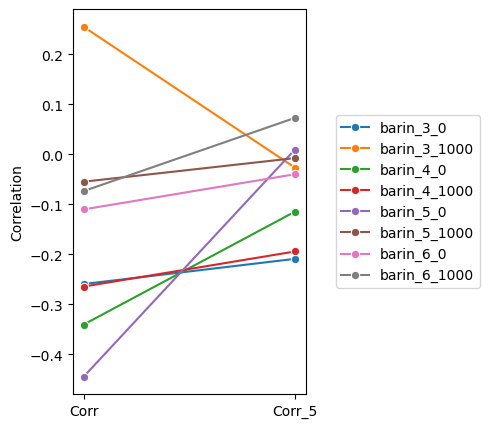

Combination: ('gray_matter', 'tumour')


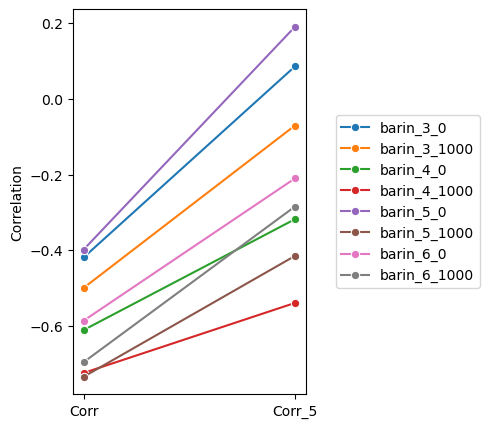

Combination: ('white_matter', 'tumour')


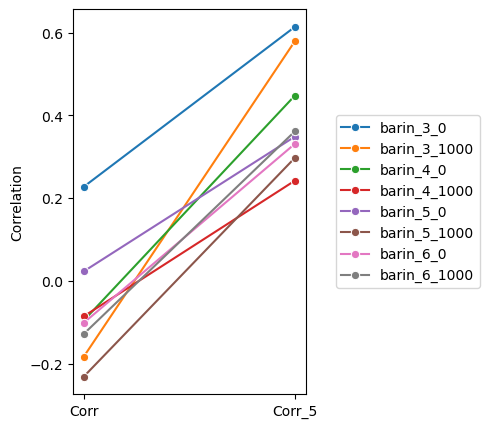

In [137]:
df = df_0
df_melted = df.melt(id_vars=["Combination", "Sample"], value_vars=["Corr", "Corr_5"], var_name="Measurement", value_name="Value")
df_melted["Sample"] = df_melted["Sample"].apply(get_plot_name)

# Loop through each unique combination
for combination in df_melted["Combination"].unique():
    # Filter the dataframe for the current combination
    df_subset = df_melted[df_melted["Combination"] == combination]

    plt.figure(figsize=(3, 5))
    
    # Plot using Seaborn
    sns.lineplot(data=df_subset, x="Measurement", y="Value", hue="Sample", marker='o')
    
    # Add title
    print(f'Combination: {combination}')
    plt.ylabel('Correlation')
    plt.xlabel('')
    plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
    
    # Show plot
    plt.show()

In [278]:
from skimage import filters

# For each sample, plot its 3 lipids
gray_matter_mzs_filter = (
    (mzs_list[0] >= 600.51 - 0.025) & (mzs_list[0] <= 600.51 + 0.025)
)
tumour_mzs_filter = (
    (mzs_list[0] >= 682.64 - 0.025) & (mzs_list[0] <= 682.64 + 0.025)
)
white_matter_mzs_filter = (
    (mzs_list[0] >= 888.62 - 0.025) & (mzs_list[0] <= 888.62 + 0.025)
)

all_ratios = {}

for i in range(0, len(samples_groups) * 2):
  ratios = {}
  for name, loop_filter in zip(["gray_matter", "white_matter", "tumour"], [gray_matter_mzs_filter, white_matter_mzs_filter, tumour_mzs_filter]):
    img = img_list[i][:,:, loop_filter].mean(axis=-1)
    ratio = (filters.threshold_mean(img) > img).sum() / img.size
    ratios[name] = ratio
  all_ratios[i] = ratios

In [279]:
flattened_data = []
for sample_idx, values_dict in all_ratios.items():
  for area, ratio in values_dict.items():
    flattened_data.append({'Sample': np.array(samples_groups).flatten()[sample_idx], 'Area': area, 'Ratio': ratio})

df = pd.DataFrame(flattened_data)
df["Day"] = df["Sample"].apply(lambda x: x.split("day_")[1][0])
df["Sample"] = df["Sample"].apply(get_plot_name)

gray_matter


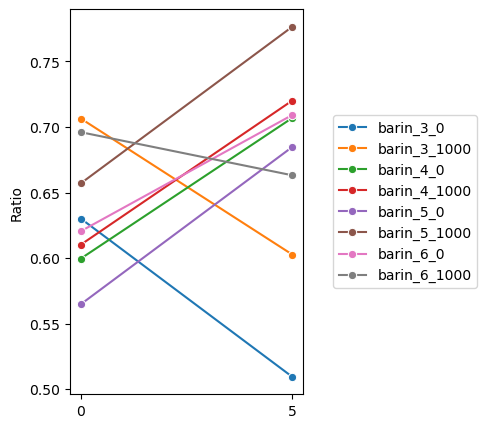

white_matter


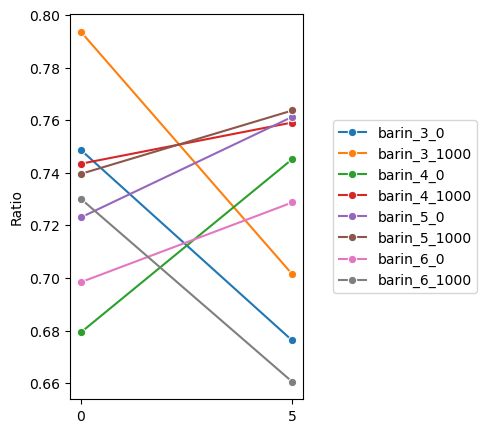

tumour


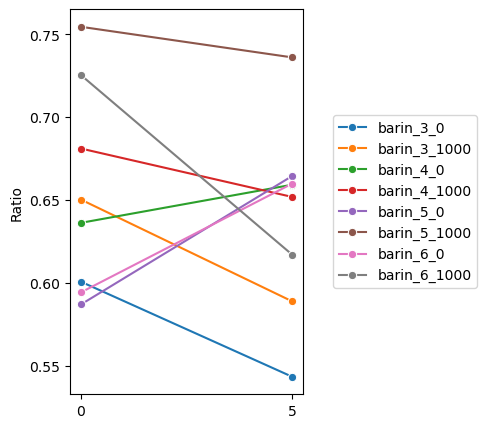

In [280]:
# Loop through each unique sample
for area in df["Area"].unique():
    # Filter the dataframe for the current sample
    df_subset = df[df["Area"] == area]
    
    # Create the plot
    plt.figure(figsize=(3, 5))  # Adjust the figure size as needed
    sns.lineplot(data=df_subset, x="Day", y="Ratio", hue="Sample", marker='o')
    
    # Add title and labels
    print(area)
    plt.xlabel('')
    plt.ylabel('Ratio')
    
    # Adjust the legend
    plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
    
    # Show plot
    plt.show()

In [242]:
thresh = 2
significant_lipids = []
for img, seg in zip(img_original_list, seg_list):
  significant_lipids.append(img[seg].mean(axis=0) >= thresh)

In [243]:
significant_lipids_in_all_0 = True

for i in range(0, len(significant_lipids), 2):
  significant_lipids_in_all_0 &= significant_lipids[i]

In [256]:
significant_lipids_in_all_5 = True
for i in range(1, len(significant_lipids) + 1, 2):
  significant_lipids_in_all_5 &= significant_lipids[i]

In [281]:
all_values_0 = {}
all_values_5 = {}

for i in range(0, len(img_list), 2):
  all_values_0[i] = {}
  all_values_5[i+1] = {}
  for j in np.where(significant_lipids_in_all_0 & ~significant_lipids_in_all_5)[0]:
    values_0 = img_list[i][seg_list[i]][:, j]
    values_5 = img_list[i+1][seg_list[i+1]][:, j]

    all_values_0[i][j] = values_0
    all_values_5[i+1][j] = values_5

: 

In [275]:
flattened_data = []
for sample_idx, values_dict in all_values_0.items():
  for mz_idx, values in values_dict.items():
    for value in values:
      flattened_data.append({'Sample': np.array(samples_groups).flatten()[sample_idx], 'mz_idx': mz_idx, 'Value': value})
for sample_idx, values_dict in all_values_5.items():
  for mz_idx, values in values_dict.items():
    for value in values:
      flattened_data.append({'Sample': np.array(samples_groups).flatten()[sample_idx], 'mz_idx': mz_idx, 'Value': value})

In [276]:
df = pd.DataFrame(flattened_data)
df["Day"] = df["Sample"].apply(lambda x: x.split("day_")[1][0])
df["Sample"] = df["Sample"].apply(get_plot_name)
df["mz_idx"] = df["mz_idx"].apply(lambda x: mzs_list[0][x])

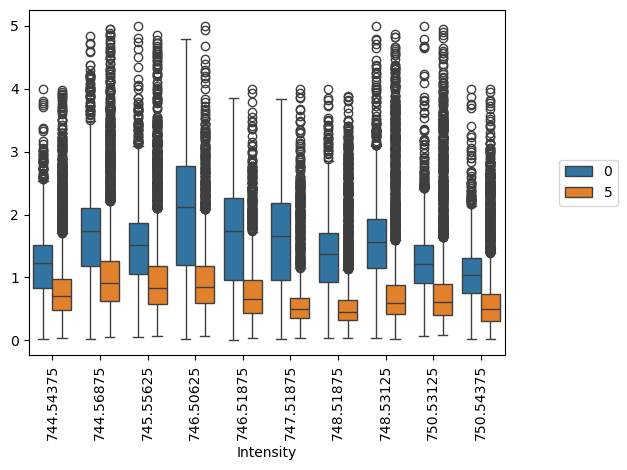

In [277]:
for sample in df["Sample"].unique():
  sns.boxplot(x='mz_idx', y='Value', hue="Day", data=df[df["Sample"] == sample])
  plt.ylabel("")
  plt.xlabel("Intensity")
  plt.xticks(rotation=90)
  plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
  plt.tight_layout()
  plt.show()

In [ ]:
# Apply clustering based on lipids that have mean value of 2 meaning they are
# significantly different from background

# Spectral Clustering Techniques: These techniques use the spectrum (eigenvalues)
# of the similarity matrix of the data to reduce dimensions before clustering 
# in fewer dimensions. This can be particularly powerful for identifying 
# clusters in complex multi-dimensional data.